# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```
## What is expected?

* Complete and run the code using `jupyter-lab`.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* If Jupyter complains issues during exporting, it is likely that [pandoc](https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry. Alternatively, use the Print function of your browser to export the PDF file.

* If Jupyter-lab does not work for you at the end, alternatively, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [2]:
# Install required packages (run this cell once if you get ModuleNotFoundError)
!pip install imageio torch numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## Q1. Download and visualise the imaging dataset.

The dataset is a public brain imaging dataset from [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from the original 3D volumes (T1-Gd contrast enhanced imaging) and downsample the 2D images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [4]:
# Download the dataset
# If you use Ubuntu, wget would natively work.
# If you use Mac or Windows, which does not have the wget command, you can copy the URL to the web browser and download the file.
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

C:\Users\Serene\AppData\Local\Temp\ipykernel_5148\1869802806.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
C:\Users\Serene\AppData\Local\Temp\ipykernel_5148\1869802806.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


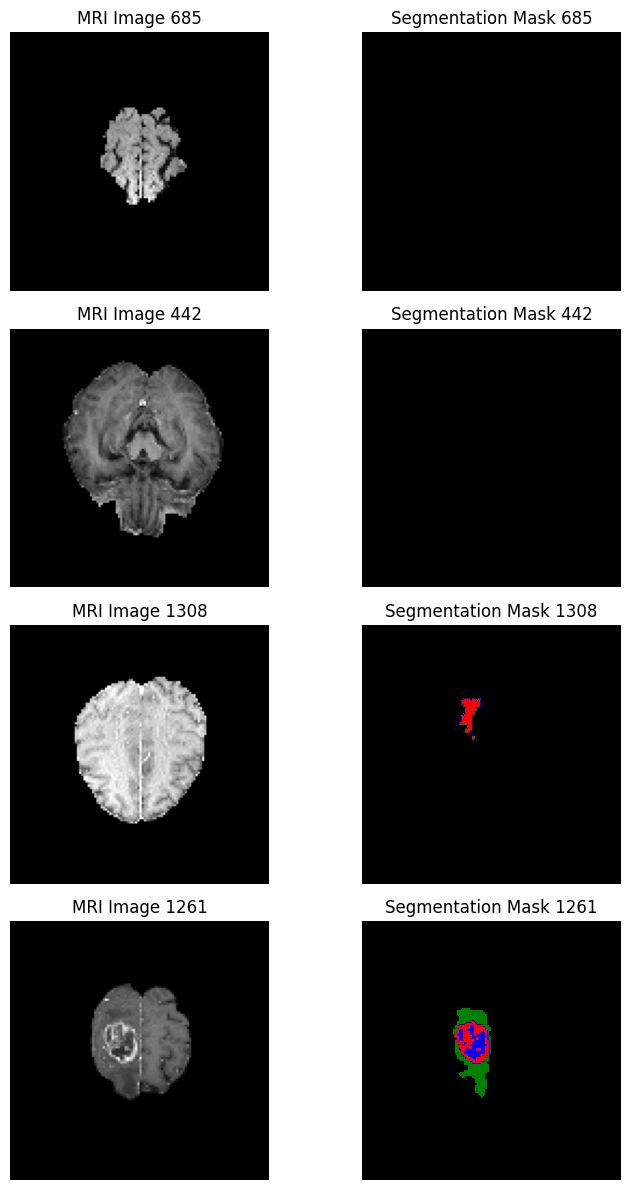

In [5]:
### Insert your code ###
data_dir = 'Task01_BrainTumour_2D'

image_dir = os.path.join(data_dir, 'training_images')
label_dir = os.path.join(data_dir, 'training_labels')

images = sorted(os.listdir(image_dir))
labels = sorted(os.listdir(label_dir))

def visualise_random_samples(image_dir, label_dir, num_samples=4):
    """ Visualise a random set of 4 training images along with their label maps """
    # Get a random set of 4 images and labels
    random_indices = random.sample(range(len(images)), num_samples)

    # define figure 
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 12))

    # define segmentation colormap
    cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

    for i, idx in enumerate(random_indices):
        # load MRI image
        img_path = os.path.join(image_dir, images[idx])
        img = imageio.imread(img_path)

        # load segmentation mask 
        mask_path = os.path.join(label_dir, labels[idx])
        mask = imageio.imread(mask_path)

        # plot MRI image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"MRI Image {idx}")
        axes[i, 0].axis('off')

        # plot segmentation mask
        axes[i, 1].imshow(mask, cmap=cmap)
        axes[i, 1].set_title(f"Segmentation Mask {idx}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# call the function
visualise_random_samples(image_dir, label_dir)
        
    
### End of your code ###

## Q2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, to be used as training batches.

In [6]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.v2.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.v2.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        
        random_indices = random.sample(range(len(self.images)), batch_size)

        for idx in random_indices:
            # normalise image
            img = normalise_intensity(self.images[idx])
            images.append(img)

            if not self.deploy:
                labels.append(self.labels[idx])
        # Return numpy arrays: images (N,1,X,Y) = NCXY, labels (N,X,Y) = NXY
        images = np.stack(images, axis=0)
        images = np.expand_dims(images, axis=1)  # add channel dim -> NCXY
        if not self.deploy:
            labels = np.stack(labels, axis=0)   # NXY
        else:
            labels = None
        ### End of your code ###
        return images, labels

## Q3. Build a U-net architecture.

Implement a U-net architecture for image segmentation. If you are not familiar with U-net, you can read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [7]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ###
        n //= 2  # 64
        self.upconv4 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 32
        self.upconv3 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 16
        self.upconv2 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.final_conv = nn.Conv2d(n, output_channel, kernel_size=1)

        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv4(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.conv5(x)

        x = self.upconv3(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.conv6(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.conv7(x)

        x = self.final_conv(x)
        ### End of your code ###
        return x

## Q4. Train the segmentation model.

In [8]:
# CUDA device (to use GPU: install PyTorch with CUDA from https://pytorch.org)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss (weighted to reduce 'all background' predictions)
# class_weights = torch.tensor([0.2, 2.0, 2.0, 2.0], device=device, dtype=torch.float32)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss() 

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Iteration {it}, Loss: {loss.item()}")
    ### End of your code ###

    # Evaluate
    if it % 1000 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            test_logits = model(test_images)
            test_loss = criterion(test_logits, test_labels)
            print(f"Test Loss: {test_loss.item()}")
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 3060
Iteration 1, Loss: 1.4434258937835693
Iteration 2, Loss: 1.3771090507507324
Iteration 3, Loss: 1.318936824798584
Iteration 4, Loss: 1.2734311819076538
Iteration 5, Loss: 1.2433305978775024
Iteration 6, Loss: 1.202945590019226
Iteration 7, Loss: 1.1842072010040283
Iteration 8, Loss: 1.1599329710006714
Iteration 9, Loss: 1.1474851369857788
Iteration 10, Loss: 1.1333725452423096
Iteration 11, Loss: 1.1117388010025024
Iteration 12, Loss: 1.085486888885498
Iteration 13, Loss: 1.0833463668823242
Iteration 14, Loss: 1.0724232196807861
Iteration 15, Loss: 1.0454787015914917
Iteration 16, Loss: 1.0326873064041138
Iteration 17, Loss: 1.0200769901275635
Iteration 18, Loss: 1.0168700218200684
Iteration 19, Loss: 1.0049383640289307
Iteration 20, Loss: 0.9884561896324158
Iteration 21, Loss: 0.9768035411834717
Iteration 22, Loss: 0.9626383185386658
Iteration 23, Loss: 0.946719229221344
Iteration 24, Loss: 0.9400566816329956
Iteration 25, 

## Q5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

C:\Users\Serene\AppData\Local\Temp\ipykernel_5148\686492767.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location = t

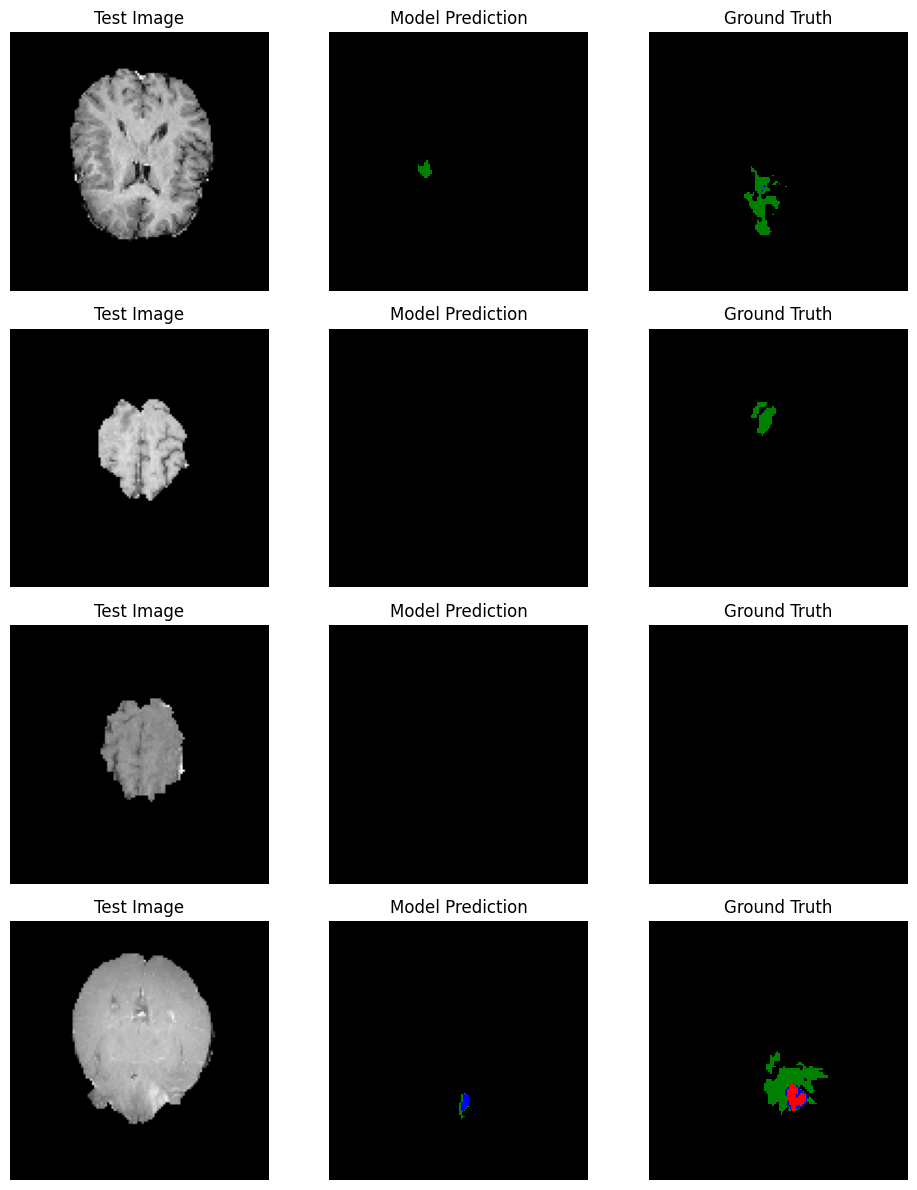

In [14]:
### Insert your code ###
model_path = "saved_models/model_10000.pt"

# load the trained model
model.load_state_dict(torch.load(model_path, map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()

num_samples = 4
# get our 4 test images and labels
test_images, test_labels = test_set.get_random_batch(num_samples)

# move to correct device and type
test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)
test_labels = torch.from_numpy(test_labels).to(device, dtype=torch.long)

# run the model at inference time with no backprop
with torch.no_grad():
    predictions = model(test_images)

# get the predictions
predictions = torch.argmax(predictions, dim=1).cpu().numpy()

# format test images + labels
test_images = test_images.cpu().numpy()
test_labels = test_labels.cpu().numpy()

# segmentation map
segmentation_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# plot the results
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 12))

for i in range(num_samples):
    # plot the test image
    axes[i, 0].imshow(test_images[i, 0], cmap='gray')
    axes[i, 0].set_title('Test Image')
    axes[i, 0].axis('off')

    # model prediction (vmin/vmax so classes 0-3 map correctly to the 4 colours)
    axes[i, 1].imshow(predictions[i], cmap=segmentation_cmap, vmin=0, vmax=3)
    axes[i, 1].set_title('Model Prediction')
    axes[i, 1].axis('off')

    # plot the ground truth segmentation
    axes[i, 2].imshow(test_labels[i], cmap=segmentation_cmap, vmin=0, vmax=3)
    axes[i, 2].set_title('Ground Truth')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### End of your code ###

## Q6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

In [ ]:
# The model sometimes gets the right answer: it correctly predicts no tumour when the ground truth is black, and it can segment small, 
# well-defined tumour regions (green = edema, blue = non-enhancing tumour, red = enhancing tumour).
#
# However, there is no single, consistent pattern to its errors. In some slices it under-segments 
# (finds only part of the tumour or misses some components). In others it produces false negatives (no tumour predicted when one is present) or
#  false positives (tumour predicted when the ground truth is black). It can also mislabel subregions 
# (e.g. red and blue where the ground truth is only green). 
# This inconsistency suggests the model has not learned a robust representation and behaves differently from slice to slice.
#
# Training loss is very low (~0.006) by 10k iterations but test loss is much higher (~0.05), 
# indicating poor generalization and possible overfitting. Class imbalance is a likely cause: with
#  unweighted cross-entropy, background dominates the loss, encouraging under-prediction of tumour and unstable behaviour. 
# To improve performance, use class-weighted cross-entropy, data augmentation, and consider architectural changes 
# (e.g. attention or a pretrained encoder). To reduce overfitting, add dropout in the U-Net decoder, use L2 
# weight decay in the optimizer (e.g. weight_decay=1e-4), and consider early stopping based on validation loss.
